https://www.kaggle.com/datasets/mohamedgobara/multi-class-knee-osteoporosis-x-ray-dataset \
https://www.kaggle.com/datasets/vuppalaadithyasairam/bone-fracture-detection-using-xrays \
https://www.kaggle.com/datasets/daverattan/dental-xrary-tfrecords \
https://www.kaggle.com/datasets/yovinyahathugoda/x-ray-body-part-dataset-512x512

### V4: find correspondence (use concatenated image)

# Attention Map

In [1]:
!hostname

gl1514.arc-ts.umich.edu


In [2]:
# CONFIG
# model_name = "facebook/dinov3-vits16-pretrain-lvd1689m"
model_name = "facebook/sam2.1-hiera-small"
data_dir = "/home/minsukc/SIO/data/"
target_image_1 = "ct_chest_2.png"
target_image_2 = "ct_chest_2_translated_100_100.png"
# target_image_2 = "ct_chest_1.jpeg"
# target_image_2 = "ct_chest_2_translated_300_300.png"

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import Sam2Processor, Sam2Model

# from transformers import AutoProcessor, Sam2VisionModel
from transformers.image_utils import load_image
import os

In [4]:
# Load model & image
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using device: {device}")

processor = Sam2Processor.from_pretrained(model_name)
sam2 = Sam2Model.from_pretrained(model_name)
model = sam2.vision_encoder
model = model.to(device)

image1 = load_image(os.path.join(data_dir, target_image_1))
image2 = load_image(os.path.join(data_dir, target_image_2))

# Match image sizes before concatenation
w1, h1 = image1.size
w2, h2 = image2.size
target_h = min(h1, h2)
target_w = min(w1, w2)

image1 = image1.resize((target_w, target_h))
image2 = image2.resize((target_w, target_h))

# 🔹 Choose concatenation direction:
concat_direction = "horizontal"  # or "vertical"

if concat_direction == "horizontal":
    concat_image = Image.new("RGB", (target_w * 2, target_h))
    concat_image.paste(image1, (0, 0))
    concat_image.paste(image2, (target_w, 0))
elif concat_direction == "vertical":
    concat_image = Image.new("RGB", (target_w, target_h * 2))
    concat_image.paste(image1, (0, 0))
    concat_image.paste(image2, (0, target_h))
else:
    raise ValueError("concat_direction must be 'horizontal' or 'vertical'")

image = concat_image

Using device: cuda


You are using a model of type sam2_video to instantiate a model of type sam2. This is not supported for all configurations of models and can yield errors.


In [5]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Load SAM2 full model
sam2 = Sam2Model.from_pretrained(model_name).to(device)

# 1) Full model size
total_params = count_params(sam2)
print(f"Total SAM2 parameters: {total_params / 1e6:.2f}M")

# 2) Vision encoder size
vision_params = count_params(sam2.vision_encoder)
print(f"SAM2 vision encoder parameters: {vision_params / 1e6:.2f}M")

# 3) Other parts (optional)
other_params = total_params - vision_params
print(f"Remaining SAM2 components: {other_params / 1e6:.2f}M")


You are using a model of type sam2_video to instantiate a model of type sam2. This is not supported for all configurations of models and can yield errors.


Total SAM2 parameters: 38.54M
SAM2 vision encoder parameters: 34.32M
Remaining SAM2 components: 4.22M


In [6]:
inputs = processor(
    images=image,
    do_resize=False,  # 🔹 disable forced 224 resize
    do_center_crop=False,  # 🔹 skip center crop
    return_tensors="pt",
).to(device)
inputs.pixel_values.shape

torch.Size([1, 3, 1024, 2048])

In [10]:
with torch.no_grad():
    # outputs = model(**inputs)
    outputs = model(**inputs, output_hidden_states=True)
    # feats = outputs.image_embeddings[0]   # [C, H', W']
    # feats = outputs.last_hidden_state[0]   # shape [C, H', W']
for i, h in enumerate(outputs.hidden_states):
    print(f"Layer {i}: {tuple(h.shape)}")

Layer 0: (1, 256, 512, 96)
Layer 1: (1, 256, 512, 96)
Layer 2: (1, 128, 256, 192)
Layer 3: (1, 128, 256, 192)
Layer 4: (1, 64, 128, 384)
Layer 5: (1, 64, 128, 384)
Layer 6: (1, 64, 128, 384)
Layer 7: (1, 64, 128, 384)
Layer 8: (1, 64, 128, 384)
Layer 9: (1, 64, 128, 384)
Layer 10: (1, 64, 128, 384)
Layer 11: (1, 64, 128, 384)
Layer 12: (1, 64, 128, 384)
Layer 13: (1, 64, 128, 384)
Layer 14: (1, 64, 128, 384)
Layer 15: (1, 32, 64, 768)
Layer 16: (1, 32, 64, 768)


In [11]:
k = -1

In [12]:
feats = outputs.hidden_states[k][0]  # [48, 48, 384]
# feats = outputs.hidden_states[10][0]  # [48, 48, 384]
# feats = outputs.hidden_states[-3][0]  # [48, 48, 384]
# feats = outputs.hidden_states[-1][0]  # [48, 48, 384]
# feats = outputs.hidden_states[-1][0]  # [48, 48, 384]
Hf, Wf, C = feats.shape
patch_feats = feats.reshape(Hf * Wf, C)  # [N_patches, C]
print(f"Feature map: {Hf}x{Wf}, dim={C}")

Feature map: 32x64, dim=768


# Patch Similarity Map

In [13]:
patch_h, patch_w = Hf, Wf
num_patches = patch_feats.shape[0]
print(f"Feature grid: {patch_h}x{patch_w}, total patches: {num_patches}")

Feature grid: 32x64, total patches: 2048


In [14]:
# --- Create a grid of query patch indices (works for non-square grids) ---
grid_size = 4  # 4x4 = 16 query points
coords_y = np.linspace(0, patch_h - 1, grid_size, dtype=int)
coords_x = np.linspace(0, patch_w - 1, grid_size, dtype=int)
query_indices = [y * patch_w + x for y in coords_y for x in coords_x]

n_queries = len(query_indices)
cols, rows = grid_size, grid_size
print(f"Query grid: {rows}x{cols}, total {n_queries} queries")

Query grid: 4x4, total 16 queries


Patch grid: 32x64, queries: 16
Similarity map shape: (32, 64)


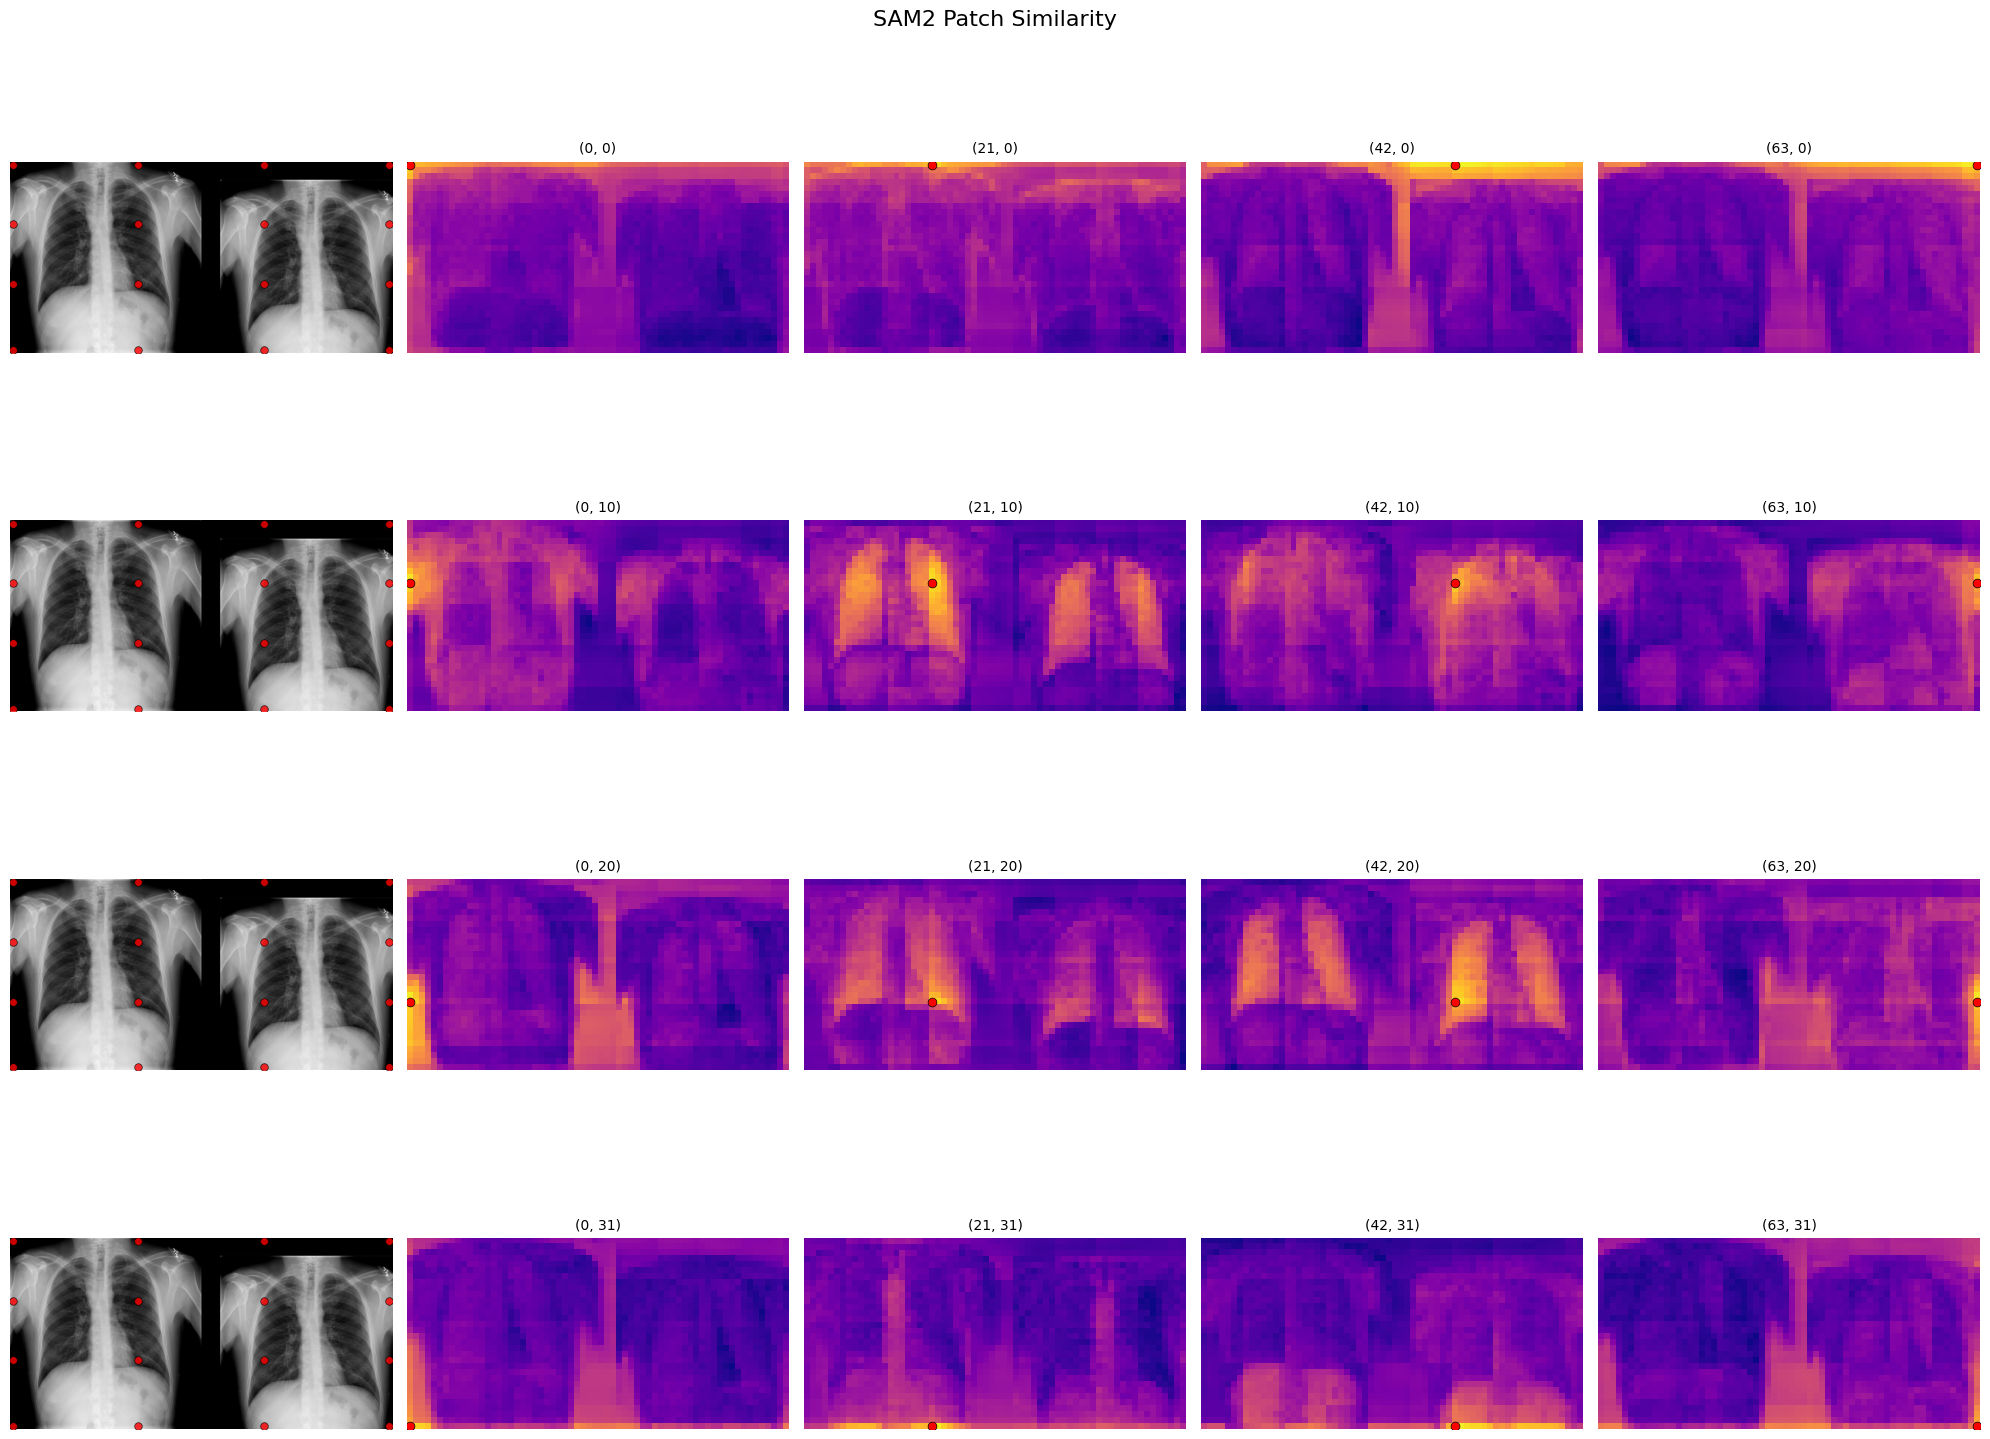

In [15]:
# --- Patch grid from feature map (robust for non-square inputs) ---
patch_h, patch_w = Hf, Wf  # from feats.shape earlier
num_patches = patch_feats.shape[0]
assert num_patches == patch_h * patch_w, (
    f"Expected {patch_h * patch_w}, got {num_patches}"
)

# --- Create evenly spaced query patches ---
grid_size = 4
coords_y = np.linspace(0, patch_h - 1, grid_size, dtype=int)
coords_x = np.linspace(0, patch_w - 1, grid_size, dtype=int)
query_indices = [y * patch_w + x for y in coords_y for x in coords_x]

cols = grid_size
rows = grid_size
print(f"Patch grid: {patch_h}x{patch_w}, queries: {len(query_indices)}")

# ---- Figure setup ----
fig, axes = plt.subplots(rows, cols + 1, figsize=(4 * (cols + 1), 4 * rows))

# ---- Left column: original image ----
for r in range(rows):
    ax_img = axes[r, 0]
    ax_img.imshow(image)
    ax_img.axis("off")

    # mark query patch centers
    for q_idx in query_indices:
        qy, qx = divmod(q_idx, patch_w)
        img_w, img_h = image.size
        center_x = (qx + 0.5) * (img_w / patch_w)
        center_y = (qy + 0.5) * (img_h / patch_h)
        ax_img.scatter(
            center_x,
            center_y,
            color="red",
            s=30,
            marker="o",
            edgecolors="black",
            linewidth=0.5,
            alpha=0.8,
        )

# ---- Right grid: similarity maps ----
ax_list = [
    axes[r, c] if rows > 1 else axes[c] for r in range(rows) for c in range(1, cols + 1)
]

for ax, q_idx in zip(ax_list, query_indices):
    query_feat = patch_feats[q_idx : q_idx + 1]
    sim = torch.nn.functional.cosine_similarity(query_feat, patch_feats)
    sim_map = sim.reshape(patch_h, patch_w).cpu().numpy()
    sim_map = (sim_map - sim_map.min()) / (sim_map.max() - sim_map.min() + 1e-8)

    qy, qx = divmod(q_idx, patch_w)
    ax.imshow(sim_map, cmap="plasma", interpolation="nearest")
    ax.scatter(qx, qy, color="red", s=40, marker="o", edgecolors="black", linewidth=0.5)
    ax.set_title(f"({qx}, {qy})", fontsize=10)
    ax.axis("off")

print(f"Similarity map shape: {sim_map.shape}")
plt.suptitle("SAM2 Patch Similarity", fontsize=16)
plt.tight_layout()
plt.show()


# PCA

In [16]:
from sklearn.decomposition import PCA

# patch_feats: [N_patches, hidden_dim], e.g., [3072, 384]
feats = patch_feats.cpu().numpy()

# Apply PCA → project hidden_dim → 3 components
pca = PCA(n_components=3)
pca_feats = pca.fit_transform(feats)  # shape: [N_patches, 3]

# Normalize each PCA channel to [0, 1]
pca_min = pca_feats.min(axis=0, keepdims=True)
pca_max = pca_feats.max(axis=0, keepdims=True)
pca_norm = (pca_feats - pca_min) / (pca_max - pca_min + 1e-8)

# --- Use true patch grid from feature map ---
patch_h, patch_w = Hf, Wf  # from feats.shape earlier

# Sanity check
num_patches = patch_feats.shape[0]
assert num_patches == patch_h * patch_w, (
    f"Expected {patch_h * patch_w}, got {num_patches}"
)

# --- Reshape PCA features into spatial layout ---
pca_image = pca_norm.reshape(patch_h, patch_w, 3)


(32, 64, 3)


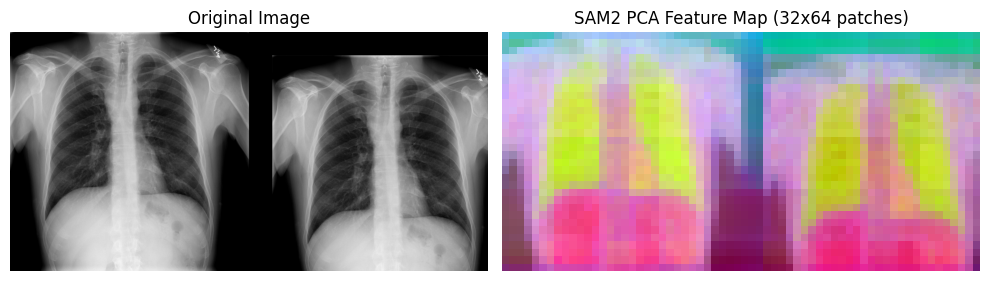

In [17]:
print(pca_image.shape)
# Display
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(pca_image, interpolation="nearest")
# axes[1].imshow(pca_image,interpolation="bilinear")
axes[1].set_title(f"SAM2 PCA Feature Map ({patch_h}x{patch_w} patches)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

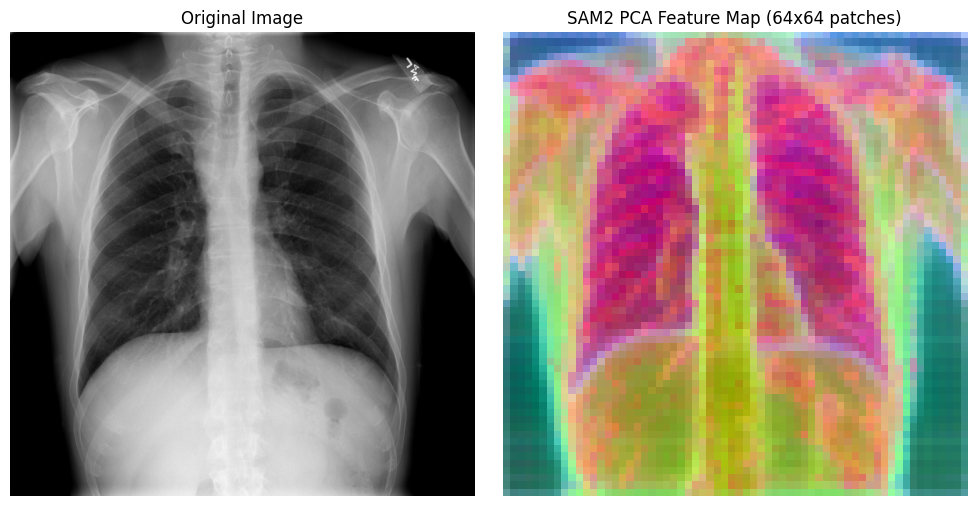

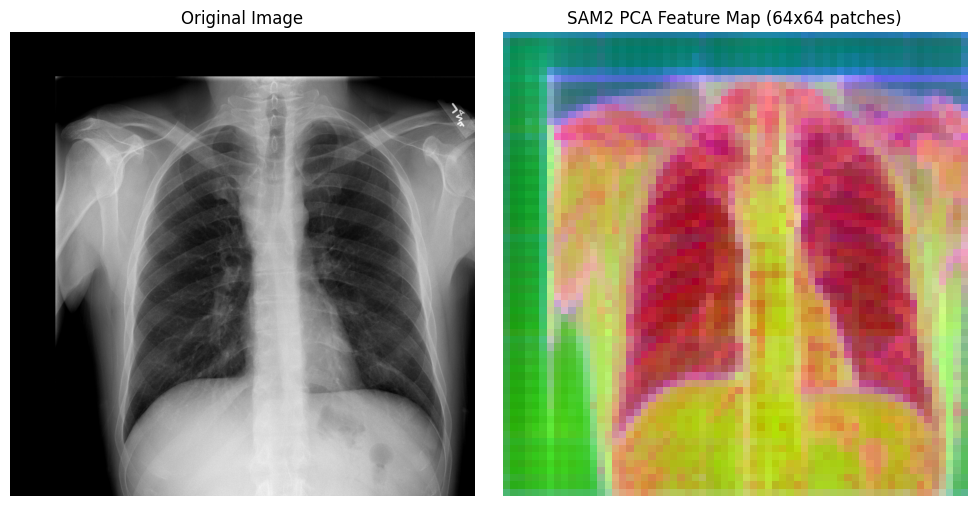

# Correspondence

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def draw_correspondences(
    imgA,
    imgB,
    HA,
    WA,
    HB,
    WB,
    match_B,
    num_samples=None,  # None = draw all
    sampling="grid",  # "grid" or "random"
):
    imgA = np.array(imgA)
    imgB = np.array(imgB)

    # match_B length = number of A patches
    N_A = len(match_B)

    # ---------------------------
    # 1) Determine patch indices to draw
    # ---------------------------
    if num_samples is None or num_samples >= N_A:
        indices = np.arange(N_A)
    else:
        if sampling == "grid":
            # pick evenly spaced indices
            indices = np.linspace(0, N_A - 1, num_samples, dtype=int)
        elif sampling == "random":
            indices = np.random.choice(N_A, num_samples, replace=False)
        else:
            raise ValueError("sampling must be 'grid' or 'random'")

    # ---------------------------
    # 2) Resize images to same height
    # ---------------------------
    h = max(imgA.shape[0], imgB.shape[0])
    imgA2 = cv2.resize(imgA, (imgA.shape[1], h))
    imgB2 = cv2.resize(imgB, (imgB.shape[1], h))

    # side-by-side canvas
    canvas = np.concatenate([imgA2, imgB2], axis=1)

    # ---------------------------
    # 3) Patch grid scaling
    # ---------------------------
    stepA_x = imgA2.shape[1] / WA
    stepA_y = h / HA
    stepB_x = imgB2.shape[1] / WB
    stepB_y = h / HB

    # ---------------------------
    # 4) Draw sampled correspondences
    # ---------------------------
    for i in indices:
        b_idx = match_B[i]

        # A patch center
        Ay = (i // WA) * stepA_y + stepA_y / 2
        Ax = (i % WA) * stepA_x + stepA_x / 2

        # B patch center
        By = (b_idx // WB) * stepB_y + stepB_y / 2
        Bx = (b_idx % WB) * stepB_x + stepB_x / 2 + imgA2.shape[1]

        pA = (int(Ax), int(Ay))
        pB = (int(Bx), int(By))

        # draw dots
        cv2.circle(canvas, pA, 5, (255, 0, 0), -1)  # blue dot on A
        cv2.circle(canvas, pB, 5, (0, 0, 255), -1)  # red dot on B

        # connect them
        cv2.line(canvas, pA, pB, (0, 255, 0), 2)

    # ---------------------------
    # 5) Display
    # ---------------------------
    plt.figure(figsize=(14, 6))
    plt.imshow(canvas)
    plt.axis("off")
    plt.title("Patch Correspondence Lines")
    plt.show()


In [19]:
# ------------------------------------------------------------
# 1) Split concatenated feature map into A and B halves
# ------------------------------------------------------------
mid = Wf // 2  # horizontal concat midpoint

coords_x = np.tile(np.arange(Wf), Hf)

mask_A = coords_x < mid
mask_B = coords_x >= mid

fA = patch_feats[mask_A]  # [N_A, C]
fB = patch_feats[mask_B]  # [N_B, C]

# spatial sizes
HA, WA = Hf, mid
HB, WB = Hf, Wf - mid

print("A:", fA.shape, "B:", fB.shape)
print("grids:", (HA, WA), (HB, WB))

# Normalize features
fA = torch.nn.functional.normalize(fA, dim=-1)
fB = torch.nn.functional.normalize(fB, dim=-1)

# ------------------------------------------------------------
# 2) Compute similarity matrix
# ------------------------------------------------------------
sim = fA @ fB.T  # [N_A, N_B]
print("sim:", sim.shape)


A: torch.Size([1024, 768]) B: torch.Size([1024, 768])
grids: (32, 32) (32, 32)
sim: torch.Size([1024, 1024])


In [20]:
def compute_correspondence(sim, WA, HA, WB, HB, r=None):
    """
    sim: [N_A, N_B] similarity matrix
    r: search radius (None = global search)
    """
    N_A = sim.shape[0]

    # Flattened B-grid coordinates (yB, xB)
    coords_y_B = np.arange(HB).repeat(WB)
    coords_x_B = np.tile(np.arange(WB), HB)

    match_B = []

    for i in range(N_A):
        # coords of patch i in A
        yA = i // WA
        xA = i % WA

        if r is None:  # -----------------------------------
            # GLOBAL SEARCH (no limits)
            # -----------------------------------------------
            best_j = sim[i].argmax().item()
            match_B.append(best_j)
            continue

        # -----------------------------------------------
        # LOCAL SEARCH within radius r
        # -----------------------------------------------
        y_min = max(0, yA - r)
        y_max = min(HB - 1, yA + r)
        x_min = max(0, xA - r)
        x_max = min(WB - 1, xA + r)

        # mask valid B patches
        mask = (
            (coords_y_B >= y_min)
            & (coords_y_B <= y_max)
            & (coords_x_B >= x_min)
            & (coords_x_B <= x_max)
        )

        valid_scores = sim[i][mask]
        valid_indices = np.where(mask)[0]

        best_j = valid_indices[valid_scores.argmax().item()]
        match_B.append(best_j)

    return np.array(match_B)


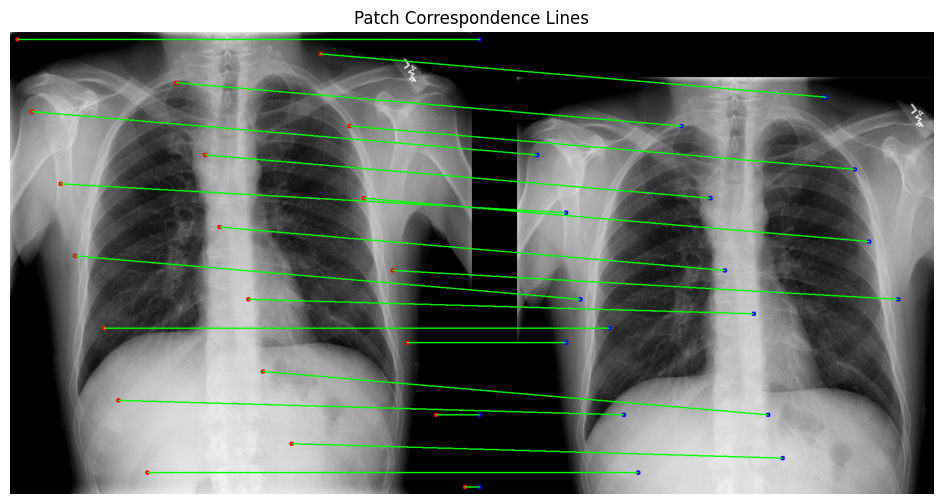

In [21]:
match_B = compute_correspondence(sim, WA, HA, WB, HB, r=None)
draw_correspondences(
    image1, image2, HA, WA, HB, WB, match_B, num_samples=20, sampling="grid"
)


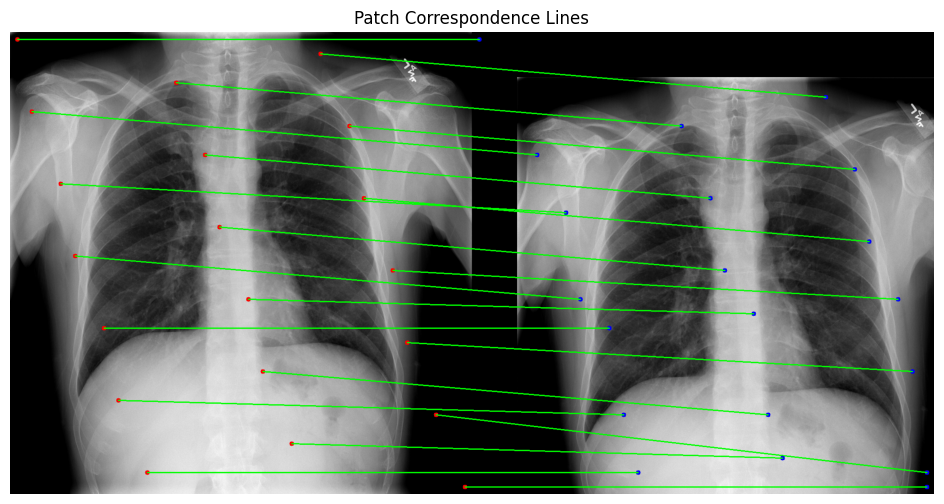

In [22]:
match_B = compute_correspondence(sim, WA, HA, WB, HB, r=4)
draw_correspondences(
    image1, image2, HA, WA, HB, WB, match_B, num_samples=20, sampling="grid"
)

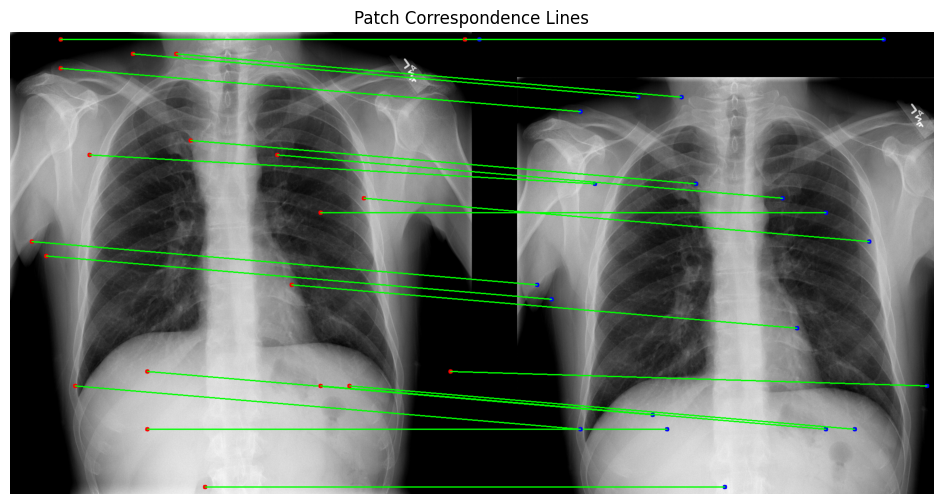

In [23]:
draw_correspondences(
    image1, image2, HA, WA, HB, WB, match_B, num_samples=20, sampling="random"
)

In [24]:
def compute_error_map_px(match_B, HA, WA, HB, WB,
                         image_width, image_height,
                         true_dx_px, true_dy_px):
    """
    Computes pixel-level correspondence error for known translation.
    match_B: flattened match indices for patches in A
    """

    # ---- 1. Patch center coords in A ----
    xs_A = np.tile(np.arange(WA), HA)
    ys_A = np.repeat(np.arange(HA), WA)

    # ---- 2. B matched patch coords ----
    xs_B = match_B % WB
    ys_B = match_B // WB

    # ---- 3. Displacement in PATCH units ----
    dx_patch = xs_B - xs_A
    dy_patch = ys_B - ys_A

    # ---- 4. Convert patch units → pixel units ----
    patch_width_px  = image_width  / WA
    patch_height_px = image_height / HA

    dx_px = dx_patch * patch_width_px
    dy_px = dy_patch * patch_height_px

    # ---- 5. Compute pixel error ----
    err_x = dx_px - true_dx_px
    err_y = dy_px - true_dy_px

    err_mag = np.sqrt(err_x**2 + err_y**2)

    # ---- 6. Return as heatmap (HA x WA) ----
    return err_mag.reshape(HA, WA)


# ---------------------------------------------
# Compute and visualize error map
# ---------------------------------------------
img_w, img_h = image1.size
true_dx_px = 100   # known translation
true_dy_px = 100

Mean Pixel Error: 66.63692148701253
Median Pixel Error: 36.22154055254967
Max Pixel Error: 431.7406628984581
Std Pixel Error: 85.57611053754272


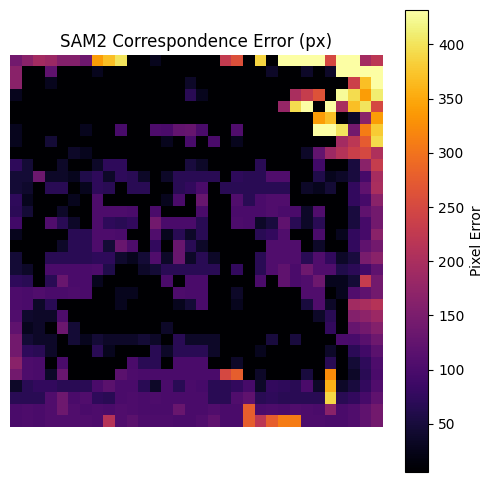

In [31]:
# match_B = compute_correspondence(sim, WA, HA, WB, HB, r=None)
match_B = compute_correspondence(sim, WA, HA, WB, HB, r=10)
# match_B = compute_correspondence(sim, WA, HA, WB, HB, r=4)
# match_B = compute_correspondence(sim, WA, HA, WB, HB, r=15)
error_img = compute_error_map_px(
    match_B,
    HA, WA, HB, WB,
    img_w, img_h,
    true_dx_px, true_dy_px
)

print("Mean Pixel Error:", np.mean(error_img))
print("Median Pixel Error:", np.median(error_img))
print("Max Pixel Error:", np.max(error_img))
print("Std Pixel Error:", np.std(error_img))

plt.figure(figsize=(6,6))
plt.imshow(error_img, cmap="inferno")
# plt.imshow(error_img, cmap="inferno", vmax=400)
plt.colorbar(label="Pixel Error")
plt.title("SAM2 Correspondence Error (px)")
plt.axis("off")
plt.show()

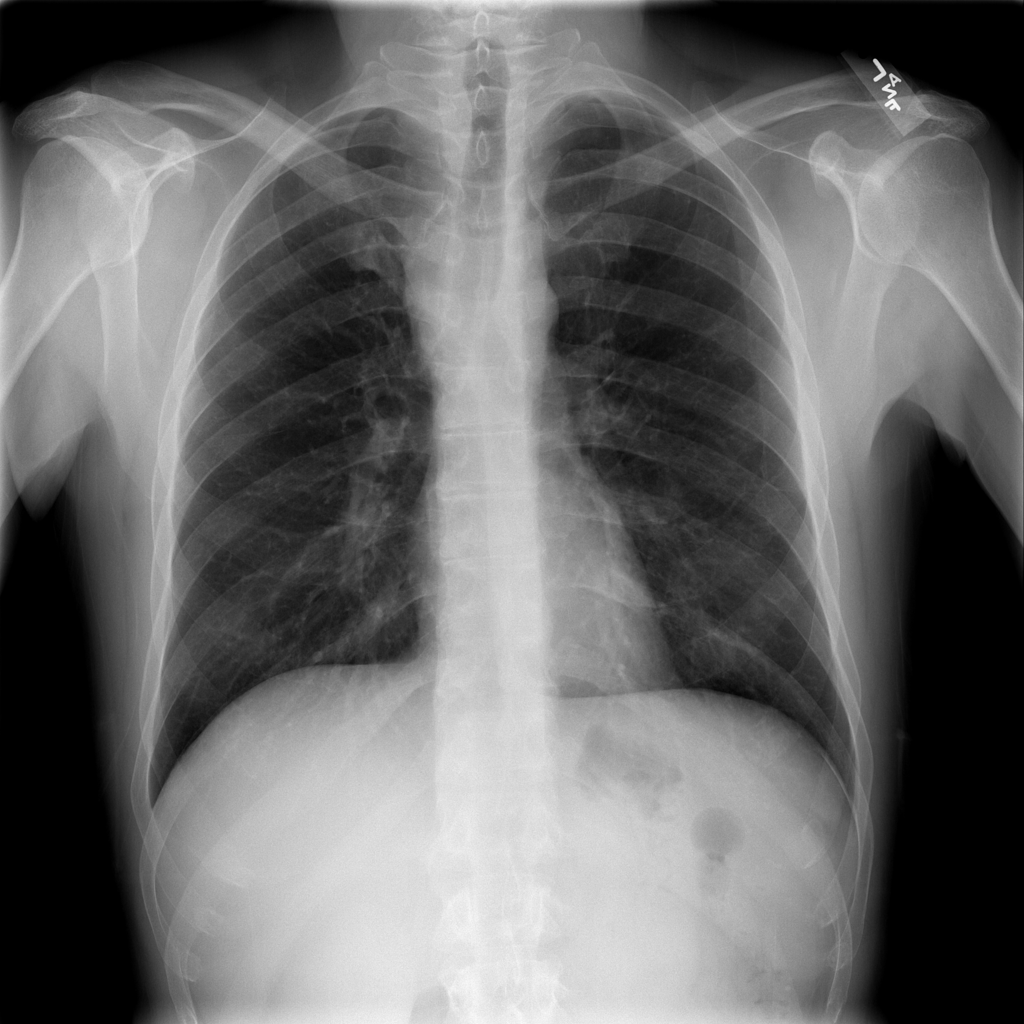

In [26]:
image1